In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from IPython.display import display
from keras.utils.vis_utils import plot_model

In [ ]:
if not os.path.isfile('processed_dataset.zip'):
  os.system(' '.join(['cp', 'drive/MyDrive/IT416/processed_dataset.zip', 'processed_dataset.zip']))

In [ ]:
if not os.path.isdir('processed_dataset'):
  os.system(' '.join(['unzip', 'processed_dataset.zip']))

In [7]:
def get_dataset(num_people):
  x1 = []
  x2 = []
  y  = []
  for i in range(num_people):
      for j in range(10):
          path = 'processed_dataset' + '/' + 'person' + str(i+1) + '/' + 'face' + '/' + str(j+1) + '.pgm'
          image = cv2.imread(path, -1)
          image = cv2.resize(image, (12, 12))
          image = image.reshape(12, 12, 1)
          x1.append(image)
      gait_folder = 'processed_dataset' + '/' + 'person' + str(i+1) + '/' + 'gait' + '/'
      styles = os.listdir(gait_folder)
      styles.sort()
      for j, style in enumerate(styles):
          style_folder = gait_folder + style + '/'
          angles = os.listdir(style_folder)
          angles.sort()
          x = []
          for angle in angles:
              angle_folder = style_folder + angle + '/'
              images = os.listdir(angle_folder)
              images.sort()
              random.shuffle(images)
              images = images[: 16]
              images.sort()
              xx = []
              for image in images:
                  path = angle_folder + image
                  img = cv2.imread(path, -1)
                  img = cv2.resize(img, (32, 32))
                  img = np.array(img, dtype=np.float16)
                  xx.append(img)
              xx = np.array(xx, dtype=np.float16)
              x.append(xx)
          x = np.stack(x, axis=3)
          x2.append(x)
      for j in range(10):
          y.append(i)
  x1 = np.array(x1, dtype = np.float32)
  x2 = np.array(x2, dtype = np.float32)
  y = tf.keras.utils.to_categorical(y)
  x1, x2, y = shuffle(x1, x2, y)
  return x1, x2, y

In [8]:
num_people = 40
x_face, x_gait, y = get_dataset(num_people)

print('x_face:', x_face.shape)
print('x_gait:', x_gait.shape)
print('y     :', y.shape)

x_face: (400, 12, 12, 1)
x_gait: (400, 16, 32, 32, 11)
y     : (400, 40)


In [13]:
face_input = tf.keras.layers.Input(shape = (12, 12, 1), name = 'face_input')

face_encoder = tf.keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', name = 'face_conv_1')(face_input)
face_encoder = tf.keras.layers.Dropout(0.2, name = 'face_dropout_1')(face_encoder)
face_encoder = tf.keras.layers.Flatten(name = 'face_flatten_1')(face_encoder)
face_encoder = tf.keras.layers.Dense(64, activation = 'relu', name = 'face_dense_1')(face_encoder)
face_encoder = tf.keras.layers.Dropout(0.2, name = 'face_dropout_2')(face_encoder)

gait_input = tf.keras.layers.Input(shape = (16, 32, 32, 11), name = 'gait_input')

gait_encoder = tf.keras.layers.ConvLSTM2D(16, kernel_size = 3, return_sequences = True, name = 'gait_convlstm_1')(gait_input)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_1')(gait_encoder)
gait_encoder = tf.keras.layers.ConvLSTM2D(8, kernel_size = 3, return_sequences = True, name = 'gait_convlstm_2')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_2')(gait_encoder)
gait_encoder = tf.keras.layers.ConvLSTM2D(1, kernel_size = 3, name = 'gait_convlstm_3')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_3')(gait_encoder)
gait_encoder = tf.keras.layers.Flatten(name = 'gait_flatten_1')(gait_encoder)
gait_encoder = tf.keras.layers.Dense(64, activation = 'relu', name = 'gait_dense_1')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_4')(gait_encoder)

def weighted_average(tensors):
  alpha = 0.5
  face = tensors[0]
  gait = tensors[1]
  weighted_average = alpha * face + (1 - alpha) * gait
  return weighted_average

decoder = tf.keras.layers.Lambda(weighted_average, name = 'face_gait_weighted_average')([face_encoder, gait_encoder])

decoder = tf.keras.layers.Dense(40, activation = 'softmax', name = 'output')(decoder)

model = tf.keras.models.Model(
      inputs = [face_input, gait_input], 
      outputs = decoder)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003), 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gait_input (InputLayer)        [(None, 16, 32, 32,  0           []                               
                                 11)]                                                             
                                                                                                  
 gait_convlstm_1 (ConvLSTM2D)   (None, 16, 30, 30,   15616       ['gait_input[0][0]']             
                                16)                                                               
                                                                                                  
 gait_dropout_1 (Dropout)       (None, 16, 30, 30,   0           ['gait_convlstm_1[0][0]']        
                                16)                                                         

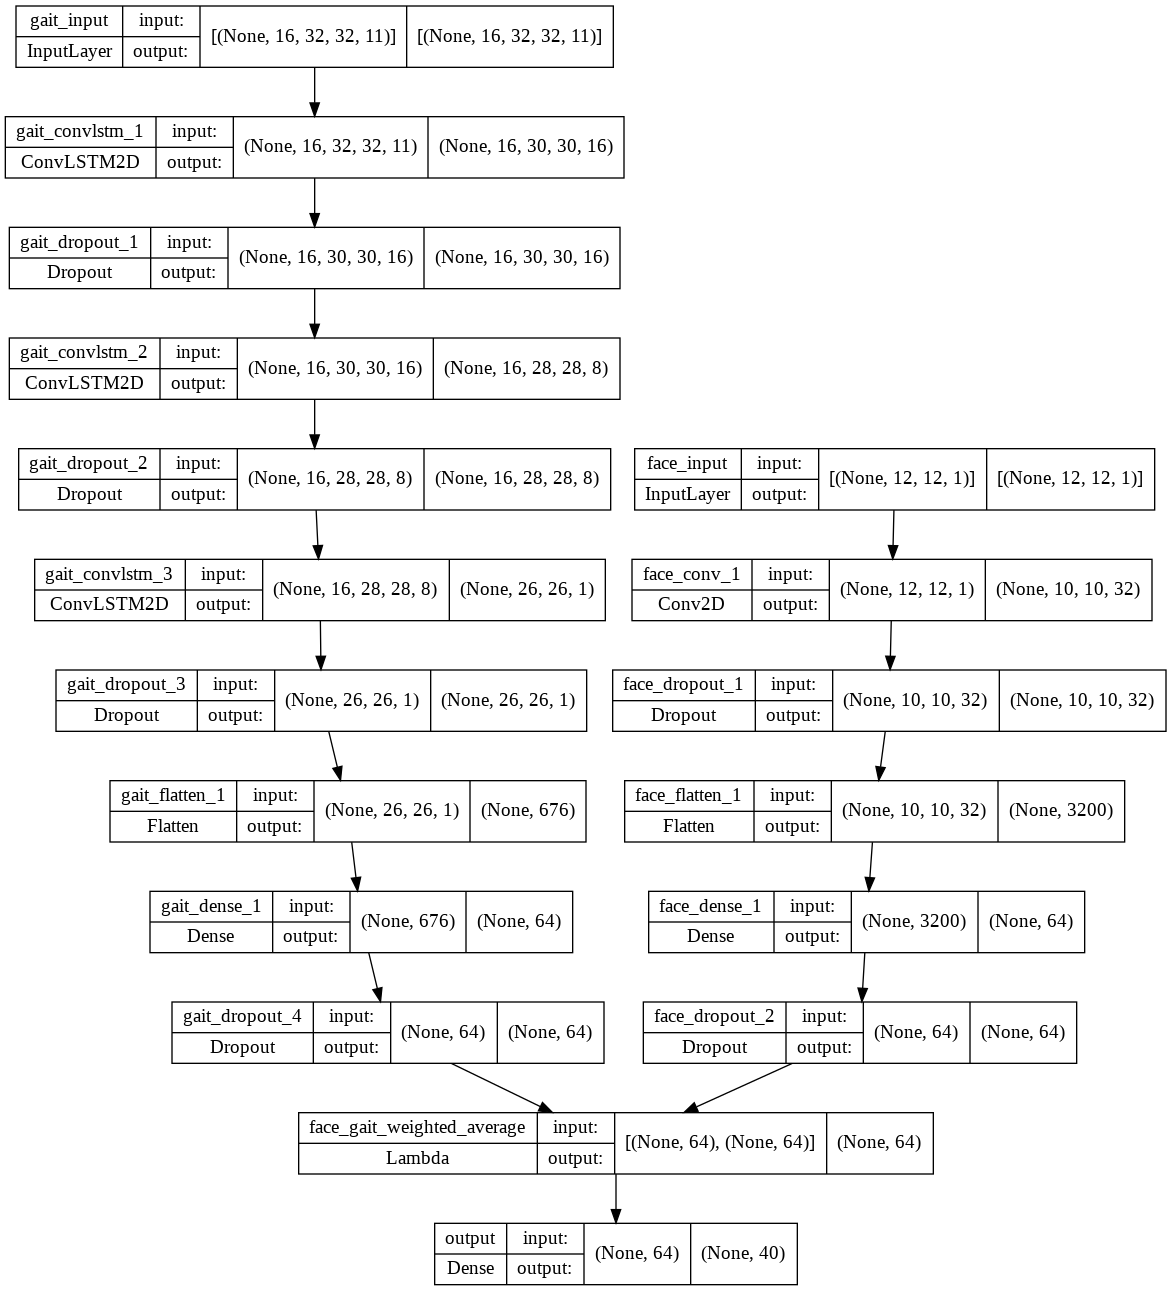

In [14]:
plot = plot_model(model, show_shapes = True, to_file = 'model.png', show_layer_names = True)
display(plot)

In [15]:
EPOCHS = 60
BATCH_SIZE = 4
VALID_SPLIT = 0.3

acc_train = []
acc_val = []

In [16]:
history = model.fit([x_face, x_gait], y, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = VALID_SPLIT)
acc_train += history.history['accuracy']
acc_val += history.history['val_accuracy']

Epoch 1/60
70/70 [==============================] - 15s 155ms/step - loss: 6.4792 - accuracy: 0.0250 - val_loss: 3.6889 - val_accuracy: 0.0250
Epoch 2/60
70/70 [==============================] - 10s 146ms/step - loss: 3.6881 - accuracy: 0.0214 - val_loss: 3.6887 - val_accuracy: 0.0250
Epoch 3/60
70/70 [==============================] - 10s 146ms/step - loss: 3.6808 - accuracy: 0.0464 - val_loss: 3.6827 - val_accuracy: 0.0417
Epoch 4/60
70/70 [==============================] - 10s 146ms/step - loss: 3.6485 - accuracy: 0.0607 - val_loss: 3.6685 - val_accuracy: 0.0500
Epoch 5/60
70/70 [==============================] - 11s 155ms/step - loss: 3.6018 - accuracy: 0.1143 - val_loss: 3.6283 - val_accuracy: 0.0833
Epoch 6/60
70/70 [==============================] - 10s 145ms/step - loss: 3.4732 - accuracy: 0.1107 - val_loss: 3.5390 - val_accuracy: 0.1167
Epoch 7/60
70/70 [==============================] - 10s 144ms/step - loss: 3.2320 - accuracy: 0.1464 - val_loss: 3.3889 - val_accuracy: 0.1000

In [17]:
history = model.fit([x_face, x_gait], y, batch_size = BATCH_SIZE, epochs = 10, validation_split = VALID_SPLIT)
acc_train += history.history['accuracy']
acc_val += history.history['val_accuracy']

Epoch 1/10
70/70 [==============================] - 11s 150ms/step - loss: 0.3629 - accuracy: 0.9107 - val_loss: 1.7555 - val_accuracy: 0.4417
Epoch 2/10
70/70 [==============================] - 10s 145ms/step - loss: 0.2853 - accuracy: 0.9250 - val_loss: 1.6945 - val_accuracy: 0.4917
Epoch 3/10
70/70 [==============================] - 10s 146ms/step - loss: 0.2503 - accuracy: 0.9357 - val_loss: 1.7322 - val_accuracy: 0.4500
Epoch 4/10
70/70 [==============================] - 10s 144ms/step - loss: 0.2960 - accuracy: 0.9250 - val_loss: 1.7441 - val_accuracy: 0.4500
Epoch 5/10
70/70 [==============================] - 10s 143ms/step - loss: 0.2685 - accuracy: 0.9357 - val_loss: 1.7890 - val_accuracy: 0.4750
Epoch 6/10
70/70 [==============================] - 10s 145ms/step - loss: 0.2806 - accuracy: 0.9321 - val_loss: 1.7506 - val_accuracy: 0.4000
Epoch 7/10
70/70 [==============================] - 10s 144ms/step - loss: 0.2900 - accuracy: 0.9286 - val_loss: 1.7256 - val_accuracy: 0.4500

In [18]:
history = model.fit([x_face, x_gait], y, batch_size = BATCH_SIZE, epochs = 10, validation_split = VALID_SPLIT)
acc_train += history.history['accuracy']
acc_val += history.history['val_accuracy']

Epoch 1/10
70/70 [==============================] - 10s 147ms/step - loss: 0.2023 - accuracy: 0.9643 - val_loss: 1.7374 - val_accuracy: 0.4750
Epoch 2/10
70/70 [==============================] - 10s 145ms/step - loss: 0.2302 - accuracy: 0.9464 - val_loss: 1.7557 - val_accuracy: 0.4667
Epoch 3/10
70/70 [==============================] - 10s 146ms/step - loss: 0.1805 - accuracy: 0.9750 - val_loss: 1.7995 - val_accuracy: 0.4417
Epoch 4/10
70/70 [==============================] - 10s 147ms/step - loss: 0.2220 - accuracy: 0.9393 - val_loss: 1.8350 - val_accuracy: 0.4583
Epoch 5/10
70/70 [==============================] - 10s 146ms/step - loss: 0.2108 - accuracy: 0.9536 - val_loss: 1.8313 - val_accuracy: 0.4417
Epoch 6/10
70/70 [==============================] - 10s 146ms/step - loss: 0.2306 - accuracy: 0.9393 - val_loss: 1.7637 - val_accuracy: 0.4667
Epoch 7/10
70/70 [==============================] - 10s 146ms/step - loss: 0.2183 - accuracy: 0.9571 - val_loss: 1.7769 - val_accuracy: 0.4833

In [19]:
history = model.fit([x_face, x_gait], y, batch_size = BATCH_SIZE, epochs = 10, validation_split = VALID_SPLIT)
acc_train += history.history['accuracy']
acc_val += history.history['val_accuracy']

Epoch 1/10
70/70 [==============================] - 10s 146ms/step - loss: 0.2297 - accuracy: 0.9571 - val_loss: 1.8141 - val_accuracy: 0.4583
Epoch 2/10
70/70 [==============================] - 10s 144ms/step - loss: 0.2014 - accuracy: 0.9500 - val_loss: 1.7695 - val_accuracy: 0.4583
Epoch 3/10
70/70 [==============================] - 10s 145ms/step - loss: 0.2042 - accuracy: 0.9464 - val_loss: 1.8092 - val_accuracy: 0.5250
Epoch 4/10
70/70 [==============================] - 10s 146ms/step - loss: 0.1846 - accuracy: 0.9679 - val_loss: 1.7721 - val_accuracy: 0.4750
Epoch 5/10
70/70 [==============================] - 10s 144ms/step - loss: 0.2135 - accuracy: 0.9429 - val_loss: 2.5031 - val_accuracy: 0.4333
Epoch 6/10
70/70 [==============================] - 10s 144ms/step - loss: 0.1820 - accuracy: 0.9571 - val_loss: 1.7473 - val_accuracy: 0.5000
Epoch 7/10
70/70 [==============================] - 10s 146ms/step - loss: 0.1734 - accuracy: 0.9679 - val_loss: 1.8375 - val_accuracy: 0.4750

In [20]:
history = model.fit([x_face, x_gait], y, batch_size = BATCH_SIZE, epochs = 10, validation_split = VALID_SPLIT)
acc_train += history.history['accuracy']
acc_val += history.history['val_accuracy']

Epoch 1/10
70/70 [==============================] - 10s 145ms/step - loss: 0.1520 - accuracy: 0.9643 - val_loss: 1.6724 - val_accuracy: 0.5167
Epoch 2/10
70/70 [==============================] - 10s 145ms/step - loss: 0.2163 - accuracy: 0.9429 - val_loss: 1.6804 - val_accuracy: 0.5250
Epoch 3/10
70/70 [==============================] - 10s 143ms/step - loss: 0.1650 - accuracy: 0.9714 - val_loss: 1.7752 - val_accuracy: 0.5250
Epoch 4/10
70/70 [==============================] - 10s 143ms/step - loss: 0.2108 - accuracy: 0.9536 - val_loss: 1.8171 - val_accuracy: 0.4333
Epoch 5/10
70/70 [==============================] - 10s 144ms/step - loss: 0.1816 - accuracy: 0.9500 - val_loss: 1.7648 - val_accuracy: 0.5000
Epoch 6/10
70/70 [==============================] - 10s 144ms/step - loss: 0.1653 - accuracy: 0.9679 - val_loss: 1.7131 - val_accuracy: 0.5000
Epoch 7/10
70/70 [==============================] - 10s 144ms/step - loss: 0.1581 - accuracy: 0.9607 - val_loss: 1.8075 - val_accuracy: 0.4667

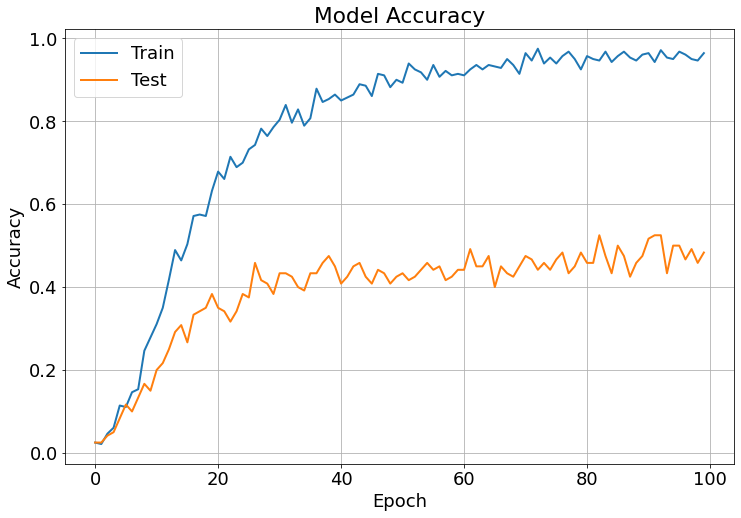

In [21]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 18

plt.plot(acc_train, linewidth=2)
plt.plot(acc_val, linewidth=2)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()

plt.show()